## Key
### scaling relation
### ejection/evaportaion timescale

### *I will also try analyzing ionization parameter U, which isn't included in this notebook.

In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii

from pathlib import Path
import matplotlib as mpl
from astropy import units as au
import yt

from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from scipy.optimize import curve_fit
from Make_figure import *
import pickle
import os
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [2]:
path='/gpfs/ckswls1699/grammar/Nx192/'
datapath=Path(path)
M5=list(datapath.glob('*M5*'))
M6=list(datapath.glob('*M6*'))
M5.sort()
M6.sort()
#M5,M6

## different initial conditions

In [3]:
def t_sample(ts,ti,val,arg=None):
    Val=0
    if arg==None:
        val_sam=np.array([val[ti>=0.99*ts[k]][0] for k in range(len(ts))])
        return val_sam
    if arg=='derivative':
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        Val=integrate(dt,val)
        Val_sam=np.array([Val[ti>=0.995*ts[k]][0] for k in range(len(ts))])
        dValdt=(Val_sam[1:]-Val_sam[:-1])/(ts[1:]-ts[:-1])
        dValdt=np.hstack([dValdt,dValdt[-1]])
        return dValdt,Val_sam

In [4]:
def dot_M_check(model,ts_arg=None):
    fig,axes=plt.subplots(1,2,figsize=(15,7))
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    if ts_arg == 'hd':
        hd=load_hd(str(model))
        ts=hd['time']
    else:
        ts=np.linspace(0,s.par['time']['tlim'],s.nums[-1])
    ti=np.array(h['time'])
    dt=ti[1:]-ti[:-1]
    dt=np.hstack([dt,dt[-1]])
    mass_ion=np.array(h['int_n_ion_dv'])*s.u.muH*(s.u.mass).value
    mass_evap = integrate(dt,h['dot_mass_ion_sphere'])
    Mis=np.array([mass_ion[ti>=0.99*ts[k]][0] for k in range(len(ts))])
    Mev=np.array([mass_evap[ti>=0.99*ts[k]][0] for k in range(len(ts))])
    dMidt=(Mis[1:]-Mis[:-1])/(ts[1:]-ts[:-1])
    dMidt=np.hstack([dMidt,dMidt[-1]])
    dMevdt=(Mev[1:]-Mev[:-1])/(ts[1:]-ts[:-1])
    dMevdt=np.hstack([dMevdt,dMevdt[-1]])
    t_cross=2*s.par['problem']['r0']/ci
    axes[0].plot(ts/t_cross,dMevdt*(s.u.mass/s.u.time).value,label='$\dot{M}_{evap}$')
    axes[0].plot(ts/t_cross,dMidt,label='$\dot{M}_{box}$')
    if ts_arg == 'hd':
        axes[0].plot(ts/t_cross,hd['M_out_ion']*(s.u.mass/s.u.time).value,label='$\dot{M}_{out}$')
        axes[0].plot(ts/t_cross,dMidt+hd['M_out_ion']*(s.u.mass/s.u.time).value,label='$\dot{M}_{box}+\dot{M}_{out}$')
    else:
        axes[0].plot(ts/t_cross,(dMevdt*(s.u.mass/s.u.time).value-dMidt),label='$\dot{M}_{out}$')
                
    axes[0].set_xlabel('$t/t_{cross}$')
    axes[0].set_ylabel('$\dot{M}$')
    axes[0].set_title(title_(str(model),['Q','n','M']))
    axes[0].legend()
    axes[0].set_xlim(s.par['problem']['t0_src']/t_cross*0.9,s.par['problem']['t0_src']+4)
    Qi=s.par['problem']['Qi']
    axes[1].plot(h['time']/t_cross,h['qi_eff']/Qi,label='qi_eff')
    axes[1].plot(h['time']/t_cross,h['qi_dust']/Qi,label='qi_dust')
    axes[1].plot(h['time']/t_cross,h['qi_eff']/Qi+h['qi_dust']/Qi,label='qi_eff+qi_dust')
    axes[1].set_xlabel('time')
    axes[1].set_ylabel('qi')
    axes[1].legend()
    return

<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3181243/3898510030.py:22: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(ts/t_cross,dMevdt*(s.u.mass/s.u.time).value,label='$\dot{M}_{evap}$')
/tmp/ipykernel_3181243/3898510030.py:23: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(ts/t_cross,dMidt,label='$\dot{M}_{box}$')
/tmp/ipykernel_3181243/3898510030.py:25: SyntaxWarning: invalid escape seque

## scaling relation

### this cell is just to get the basic data of each model, such as nH0, Qi, Sigma, M0, etc...

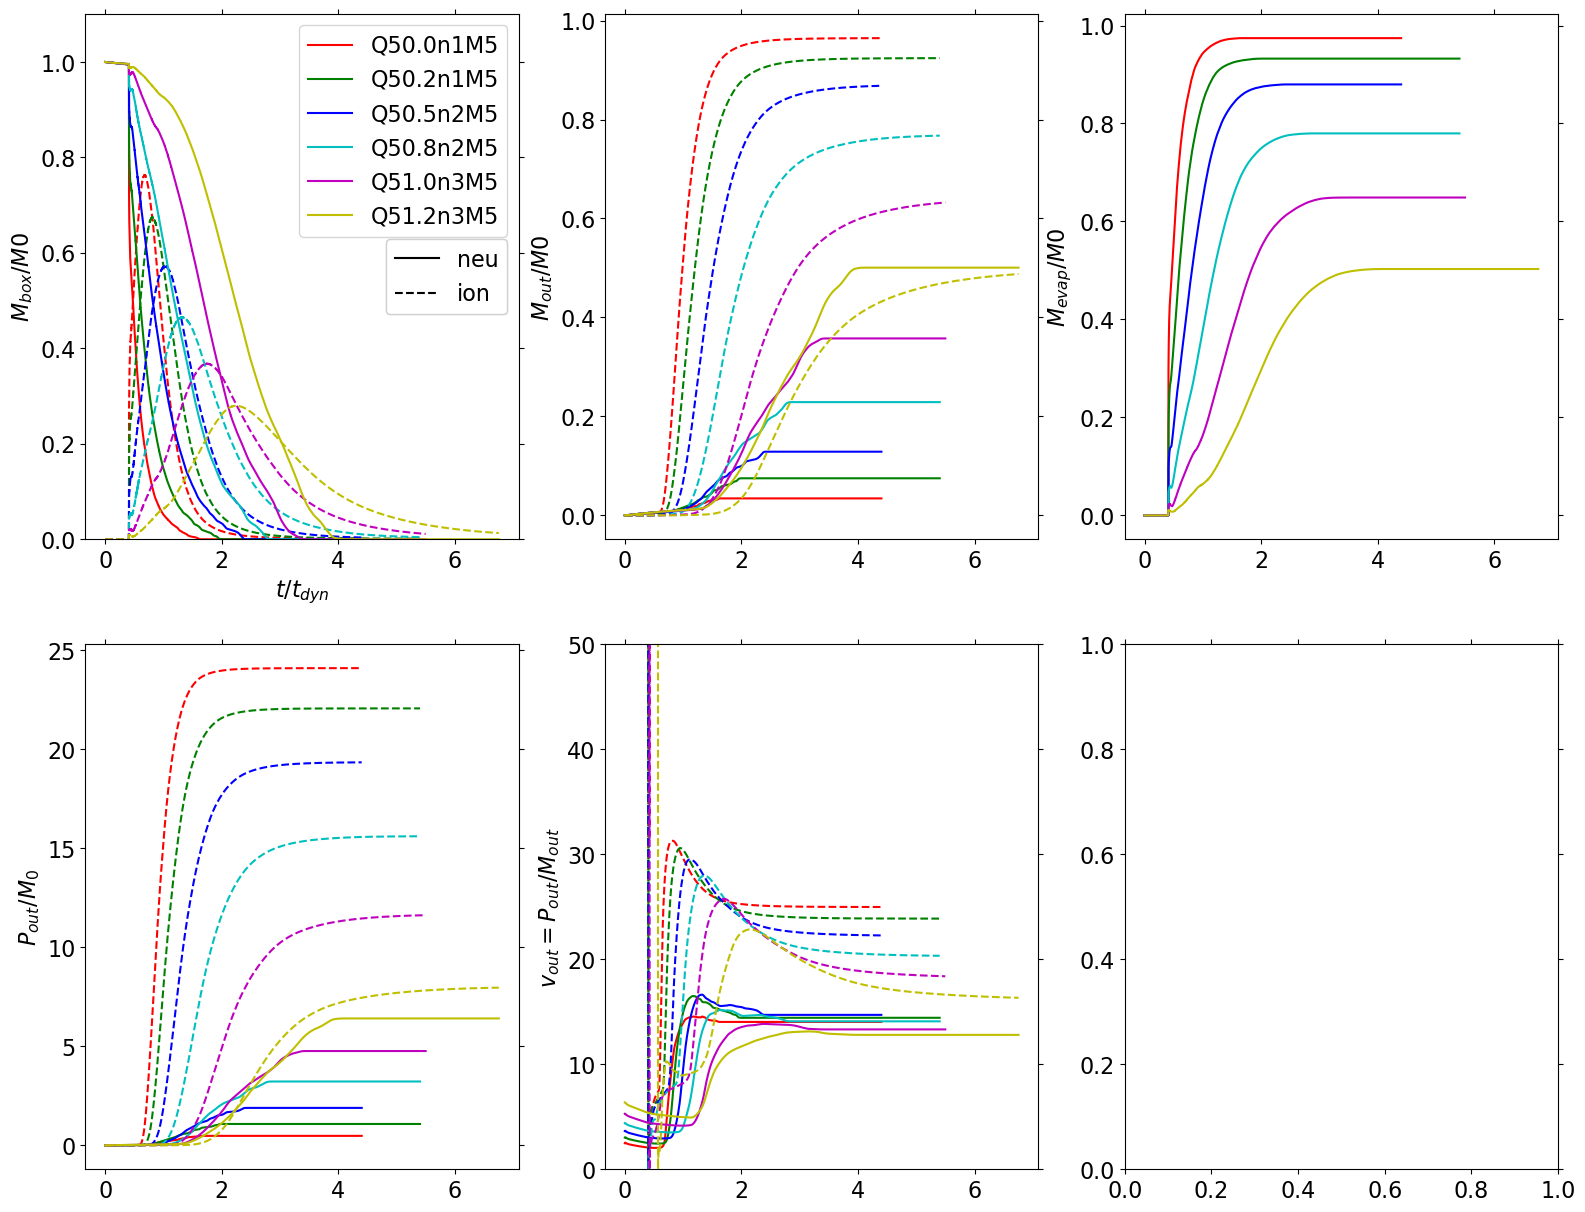

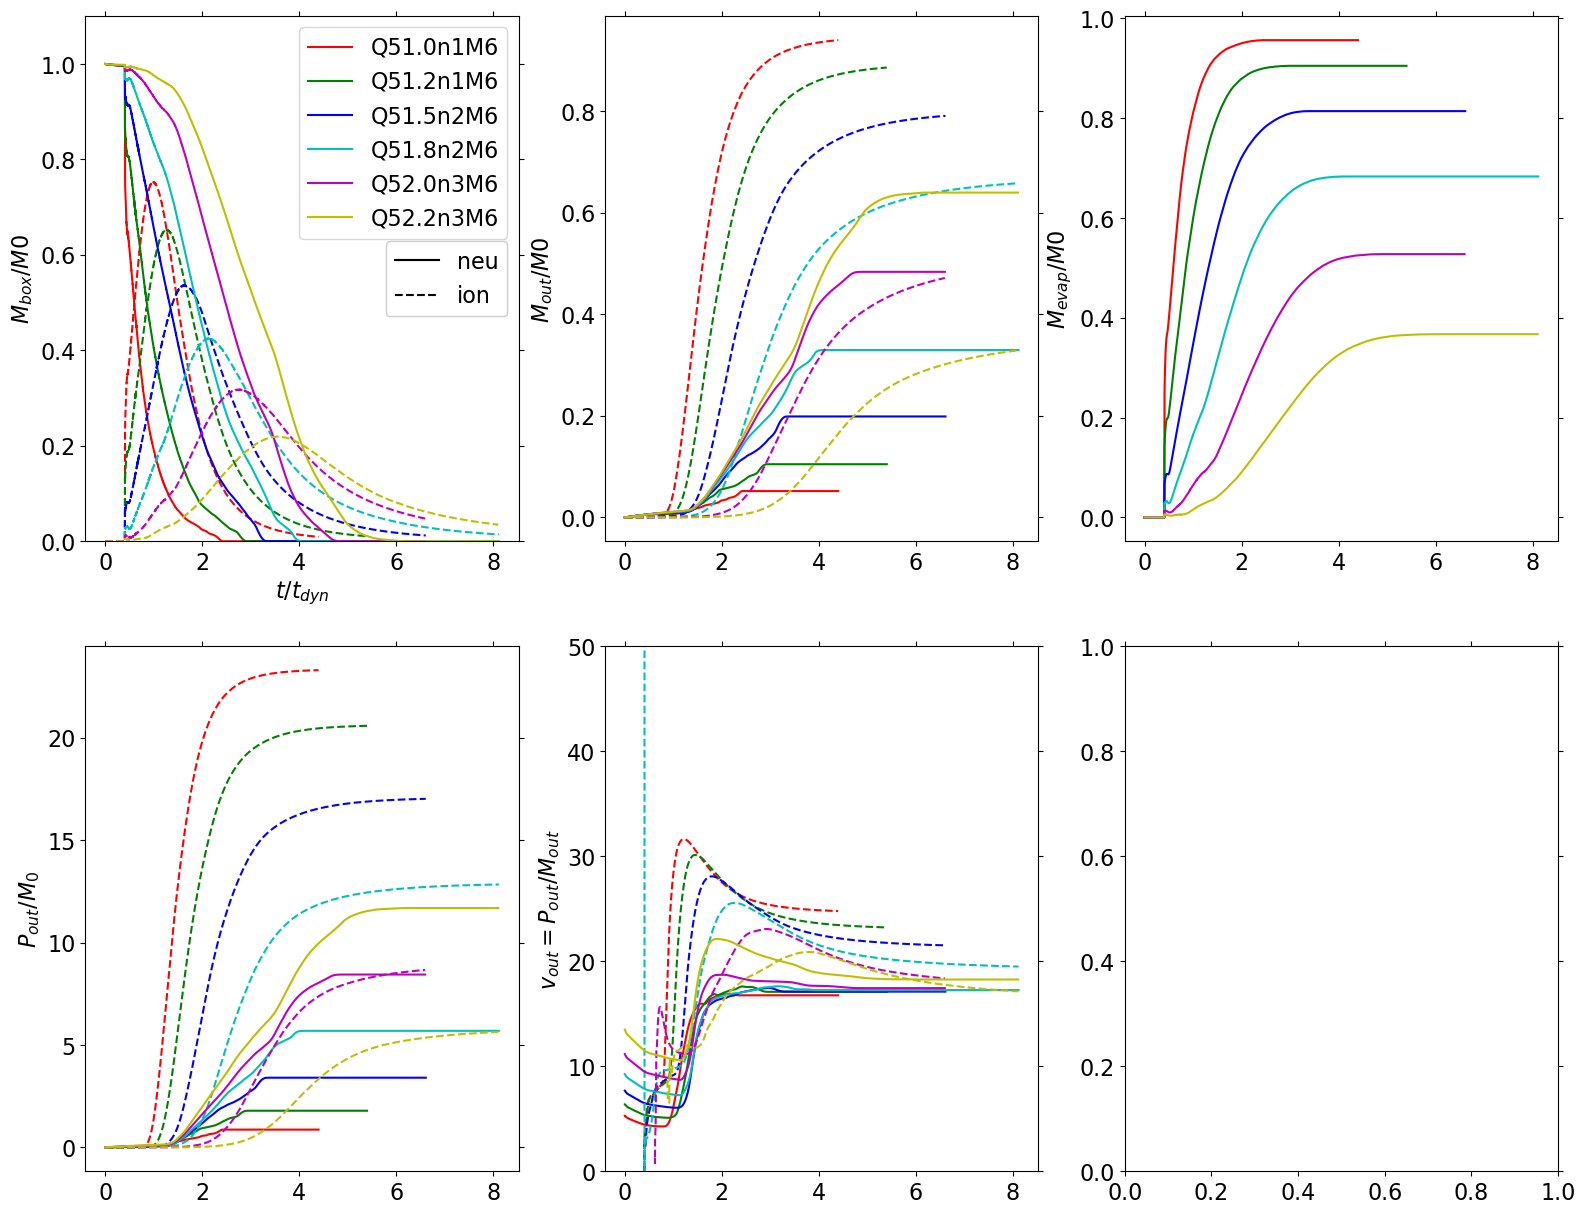

In [5]:
D5=hists(M5)
D6=hists(M6)

### function for outflow mass scaling relation and average method.

In [6]:
def M_dot_scale(models,mode=None):
    x_arr,x_w_arr,val_arr,val_w_arr,scale_arr,scale_w_arr=np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
    if mode == 'plot':
        fig,axes=plt.subplots(3,2,figsize=(15,23))    
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(str(model))    

## proper combination of Qi and nH0 for relation.
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(2/3)/n2**(1/3)
        x[~(x>0)]=0
        
## plot mass outflow rate
        M_out_scale=4.99*1000*x*0.8**1.04
        M_out=hd['M_out_ion']*s.u.mass/s.u.time
        if mode == 'plot':
            axes[0][0].loglog(x,M_out,label=str(model).split('/')[-1])
            axes[0][1].semilogx(x,M_out/M_out_scale,label=str(model).split('/')[-1])
            t_ff=t_ff_(str(model))

## additinal plot for f_wind, v_ej, etc... as functions of x or time.
            axes[1][0].semilogx(x,hd['f_wind'])
            axes[1][1].semilogx(x,hd['P_out_ion']/hd['M_out_ion'])
            axes[2][0].semilogy(hd['time']/t_ff,Qi49**(2/3)*n2**(-1/3))
            axes[2][1].plot(hd['time']/t_ff,hd['P_out_ion']/hd['M_out_ion'])
            #axes[1][1].semilogx(Qi49**(2/3)*n2**(-1/3),hd['vr_w_mass'])

## average method - simple time-average(weights = dt)
## select time interval for integration.
## t_dest=t_{ion,5%}, t_start=t0_src
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        t_start=s.par['problem']['t0_src']
        #t_dest=s.par['time']['tlim']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]

        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        ti=hd['time']
        dt=(ti[ind])[1:]-(ti[ind])[:-1]
        dt=np.hstack([dt,dt[-1]])
        #dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum(((hd['M_out_ion']*s.u.mass/s.u.time).value)[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(M_out_scale[ind]*w)/(np.sum(w))])

## average method - weights=dot{M}_{out}. no need to select time interval.        
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        w=hd['M_out_ion']*dt
        x_w_arr=np.hstack([x_w_arr,np.sum(x*w)/(np.sum(w))])
        val_w_arr=np.hstack([val_w_arr,np.sum(((hd['M_out_ion']*s.u.mass/s.u.time).value)*w)/(np.sum(w))])
        scale_w_arr=np.hstack([scale_w_arr,np.sum(M_out_scale*w)/(np.sum(w))])

## figure setting
    if mode == 'plot':
        axes[2][0].set_xlabel('$t/t_{dyn}$')
        axes[2][0].set_ylabel('$f_{wind}$')
        #x=Qi49^(2/3)*n^(-1/3)
        x=np.logspace(-1,2,100)
        M_out_scale=4.99*1000*x*0.8**1.04
        axes[0][0].loglog(x,M_out_scale,'--')
        axes[0][0].loglog(x_arr,val_arr,'k*',ms=10)
        axes[0][1].semilogx(x_arr,val_arr/scale_arr,'k*',ms=10)
        axes[0][0].loglog(x_w_arr,val_w_arr,'r*',ms=10)
        axes[0][1].semilogx(x_w_arr,val_w_arr/scale_w_arr,'r*',ms=10)
        axes[0][0].set_xlabel('$Q_{i,eff}^{2/3}n_{rms,ion}^{-1/3}$')
        axes[0][0].set_ylabel('$\dot{M}_{out,ion}$')
        axes[0][1].set_ylabel('$\dot{F}_M$')
        axes[1][1].set_ylabel('$v_{r}(r_{cl})$')
        axes[0][0].set_xlim(1e-1,1e2)
        axes[0][0].set_ylim(1e+3,1e6)
        axes[0][1].set_xlim(1e-1,1e2)
        axes[0][1].set_ylim(0,3)
        axes[1][0].set_xlim(1e-1,1e2)
        axes[1][1].set_xlim(1e-1,1e2)
        axes[1][1].set_ylim(0,30)
        axes[2][1].set_ylim(0,30)
        
    return x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr

<>:71: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3181243/255068038.py:71: SyntaxWarning: invalid escape sequence '\d'
  axes[0][0].set_ylabel('$\dot{M}_{out,ion}$')
/tmp/ipykernel_3181243/255068038.py:72: SyntaxWarning: invalid escape sequence '\d'
  axes[0][1].set_ylabel('$\dot{F}_M$')


In [46]:
x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr=M_dot_scale(M5)
x_arr2,val_arr2,scale_arr2,x_w_arr,val_w_arr2,scale_w_arr2=M_dot_scale(M6)

### I tried calculating average value not only with weights=dt, but also weights=$dM_{out}$, which tends to emphasize the snapshot when $\dot{M}_{out}$ becomes maximum.
### the below graph is the result of time-averaged value.
### At meeting, there was the decreasing tendency of F values, but I found that it was the result from the selection of time interval $t_{out,max} \sim t_{ion,5\%}$. 
### the reason I tried this selection was outflow rate seemed to follow the scaling relation well after it arrived at the max value.
### because of this result, some problem emerges. this result is same when weights=$dM_{out}$ is used (although there is the difference in F value.)
### At the same time, the scaling relation of radial momentum outflow still shows the decreasing tendency as density increases, and weights=$dP_{out}$ also yields the similar tendency. So, the discussion at the last meeting about ejection velocity may be effective.
### Can we interpret this result of $F_{\dot{M}}$ and $F_{\dot{P}}$ as the expectation in HII-WIND paper?(weakly dependent $F_{\dot{M}}$ and decreasing $F_{\dot{P}}$ as increases 'a' parameter, which we expect to increase as the cloud density increases)

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2895391/4262085366.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{M}_{out}$')
/tmp/ipykernel_2895391/4262085366.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{M}_{out,scale}$')
/tmp/ipykernel_2895391/4262085366.py:9: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{M}_{out}$')
/tmp/ipykernel_2895391/4262085366.py:10: SyntaxWarning: invalid escape sequence '\d'
  axes[1].set_ylabel('$F_{\dot{M}}$')


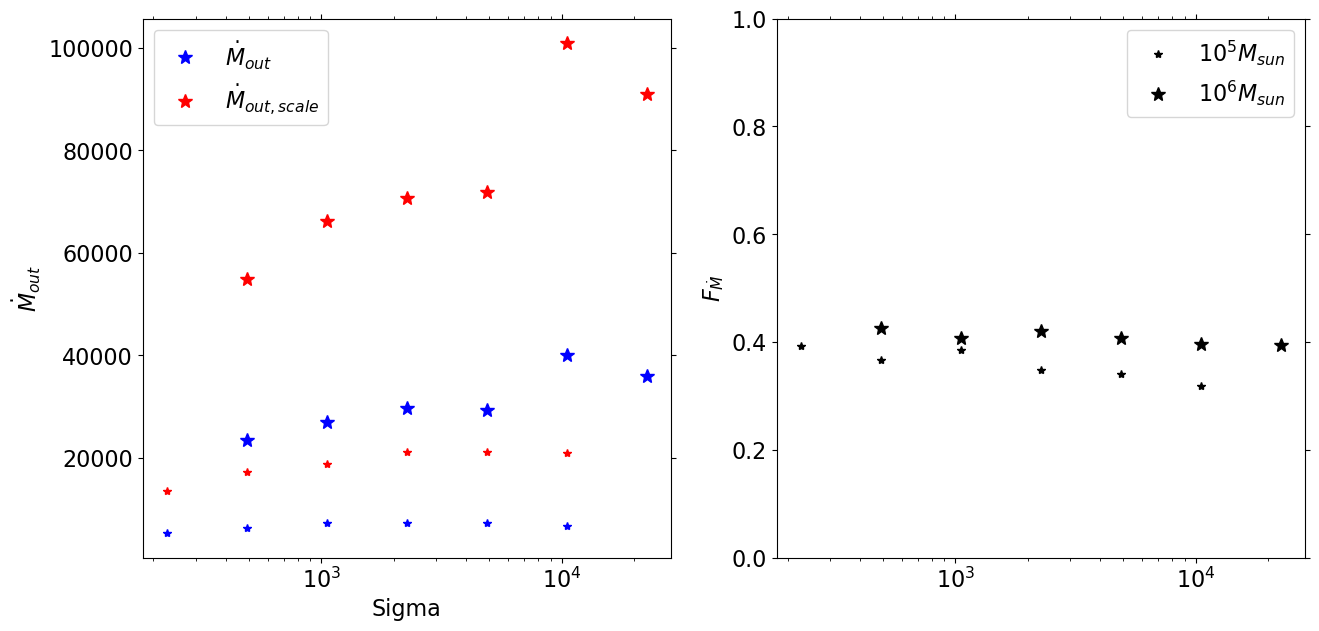

In [48]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{M}_{out}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{M}_{out,scale}$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$\dot{M}_{out}$')
axes[1].set_ylabel('$F_{\dot{M}}$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

### the below graph is the result of out flow mass-weighted average value.
### there is some difference in $F_{\dot{M}}$. this average method results in nearly constant F value.
### Especially, in M6 models, $F_{\dot{M}}$ seems nearly constant.

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2895391/1394728731.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],val_w_arr2,'b*',ms=10,label='$\dot{M}_{out}$')
/tmp/ipykernel_2895391/1394728731.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],scale_w_arr2,'r*',ms=10,label='$\dot{M}_{out,scale}$')
/tmp/ipykernel_2895391/1394728731.py:9: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{M}_{out}$')
/tmp/ipykernel_2895391/1394728731.py:10: SyntaxWarning: invalid escape sequence '\d'
  axes[1].set_ylabel('$F_{\dot{M}}$')


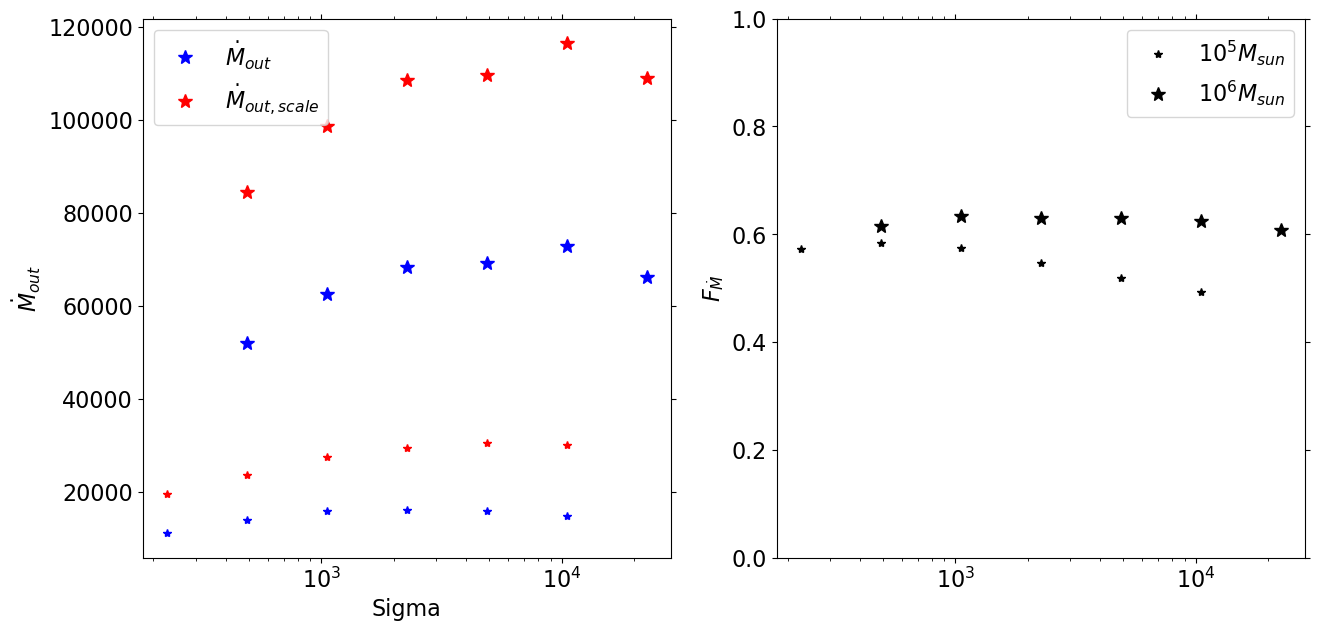

In [50]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_w_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_w_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_w_arr/scale_w_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_w_arr2,'b*',ms=10,label='$\dot{M}_{out}$')
axes[0].semilogx(D6['Sig'],scale_w_arr2,'r*',ms=10,label='$\dot{M}_{out,scale}$')
axes[1].semilogx(D6['Sig'],val_w_arr2/scale_w_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$\dot{M}_{out}$')
axes[1].set_ylabel('$F_{\dot{M}}$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

## function for scaling and average value of momentum outflow

In [54]:
def P_dot_scale(models,mode=None):
    x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr=np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
    Ti4=0.8
    if mode == 'plot':
        fig,axes=plt.subplots(1,2,figsize=(15,7))
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(s.basedir)

## proper combination for scaling relation.
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(2/3)*n2**(-1/3)
        x[~(x>0)]=0

## radial momentum outflow and scaling relation.
        P_dot_scale=5.55*10000*x*Ti4**1.54
        P_out = hd['P_out_ion']*s.u.mass/s.u.time
        if mode == 'plot':
            axes[0].loglog(Qi49**(2/3)*n2**(-1/3),P_out,label=title_(str(model),['Q','n','M']))
            axes[1].semilogx(Qi49**(2/3)*n2**(-1/3),P_out/P_dot_scale)

## average method - simple time averaged value(weights = dt)
## selection time interval for integration.
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        t_start=s.par['problem']['t0_src']
        #t_dest=s.par['time']['tlim']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        ti=hd['time'][ind]
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        #dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        #w=dMevs[ind]*dt
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum(((hd['P_out_ion']*s.u.mass/s.u.time).value)[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(P_dot_scale[ind]*w)/(np.sum(w))])

## average method - weights = dot{P}_{out}
        ti=hd['time']
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        w=hd['P_out_ion']*dt
        x_w_arr=np.hstack([x_w_arr,np.sum(x*w)/(np.sum(w))])
        val_w_arr=np.hstack([val_w_arr,np.sum(((hd['P_out_ion']*s.u.mass/s.u.time).value)*w)/(np.sum(w))])
        scale_w_arr=np.hstack([scale_w_arr,np.sum(P_dot_scale*w)/(np.sum(w))])
## figure setting
    if mode=='plot':
        x=np.logspace(-1,2,100)
        P_dot_scale=5.55*10000*x*Ti4**1.54
        axes[0].loglog(x,P_dot_scale,'--')
        axes[0].loglog(x_arr,val_arr,'k*',ms=10)
        axes[1].semilogx(x_arr,val_arr/scale_arr,'k*',ms=10)
        axes[0].loglog(x_w_arr,val_w_arr,'r*',ms=10)
        axes[1].semilogx(x_w_arr,val_w_arr/scale_arr,'r*',ms=10)
        axes[0].set_xlabel('$Q_{i,eff}^{2/3}n_{rms,ion}^{-1/3}$')
        axes[0].set_ylabel('$\dot{P}_{out,ion}$')    
        axes[0].set_xlim(1e-1,1e+2)
        axes[0].set_ylim(1e+2,1e+7)
        axes[1].set_ylim(0,3)
    return x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr

<>:60: SyntaxWarning: invalid escape sequence '\d'
<>:60: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2895391/574072526.py:60: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{P}_{out,ion}$')


In [55]:
x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr=P_dot_scale(M5)
x_arr2,val_arr2,scale_arr2,x_w_arr2,val_w_arr2,scale_w_arr2=P_dot_scale(M6)

### result of simple time-averaged outflow momentum

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2895391/647768635.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{P}_{out}$')
/tmp/ipykernel_2895391/647768635.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{P}_{out,scale}$')
/tmp/ipykernel_2895391/647768635.py:9: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{P}_{out}$')
/tmp/ipykernel_2895391/647768635.py:10: SyntaxWarning: invalid escape sequence '\d'
  axes[1].set_ylabel('$F_{\dot{P}}$')


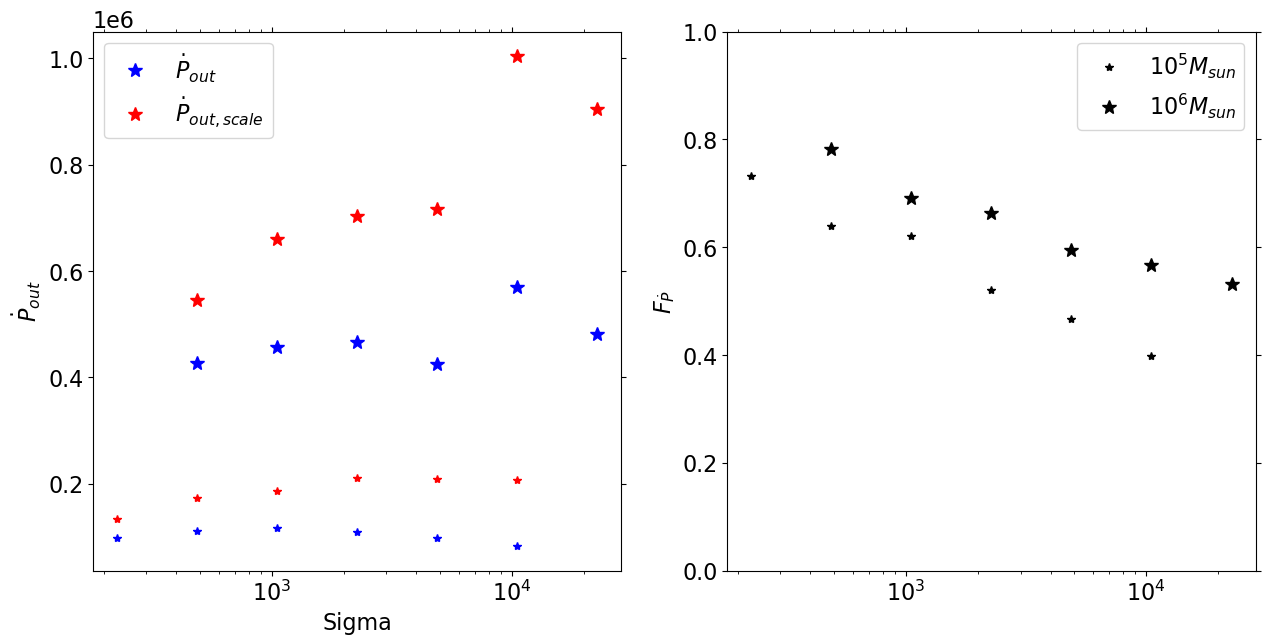

In [57]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{P}_{out}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{P}_{out,scale}$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$\dot{P}_{out}$')
axes[1].set_ylabel('$F_{\dot{P}}$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

### result of outflow momentum-weighted average value

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2895391/3433248928.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],val_w_arr2,'b*',ms=10,label='$\dot{P}_{out}$')
/tmp/ipykernel_2895391/3433248928.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],scale_w_arr2,'r*',ms=10,label='$\dot{P}_{out,scale}$')
/tmp/ipykernel_2895391/3433248928.py:9: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{P}_{out}$')
/tmp/ipykernel_2895391/3433248928.py:10: SyntaxWarning: invalid escape sequence '\d'
  axes[1].set_ylabel('$F_{\dot{P}}$')


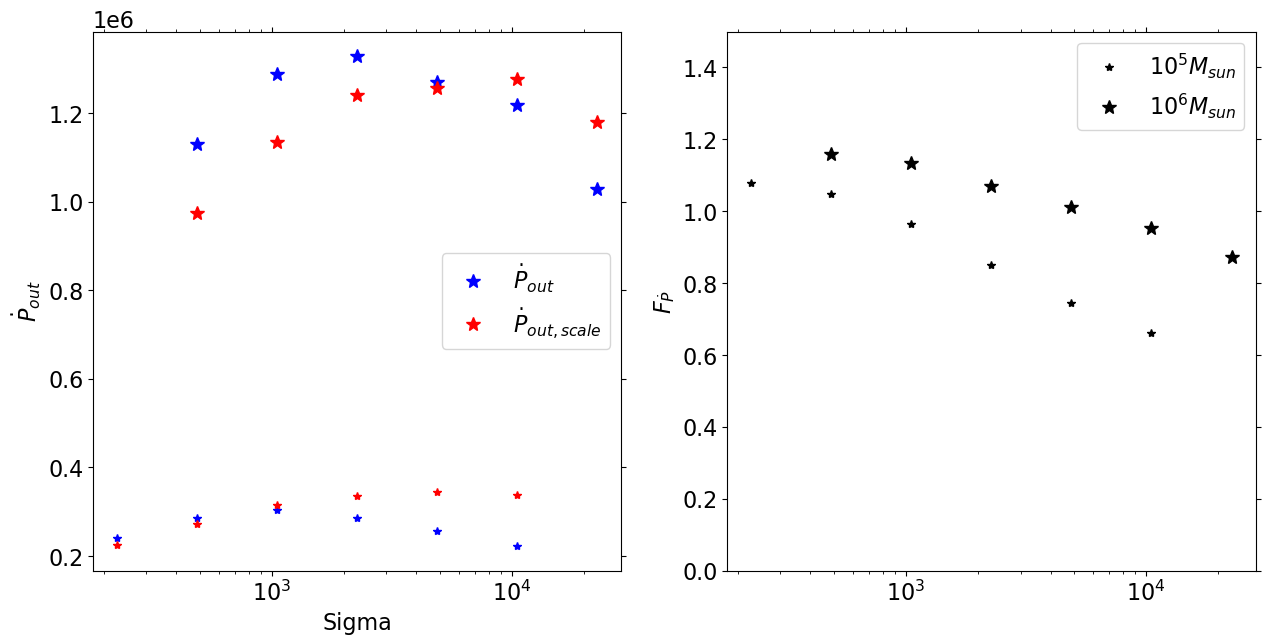

In [58]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_w_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_w_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_w_arr/scale_w_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_w_arr2,'b*',ms=10,label='$\dot{P}_{out}$')
axes[0].semilogx(D6['Sig'],scale_w_arr2,'r*',ms=10,label='$\dot{P}_{out,scale}$')
axes[1].semilogx(D6['Sig'],val_w_arr2/scale_w_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$\dot{P}_{out}$')
axes[1].set_ylabel('$F_{\dot{P}}$')
axes[0].legend()
axes[1].set_ylim(0,1.5)

axes[1].legend()

In [49]:
#fig,axes=plt.subplots(1,2,figsize=(15,7))
Mev_arr,Pscale_arr,Mout_arr,P_arr,Pout_arr=[],[],[],[],[]

for model in M5:
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    mev=np.array(h['dot_mass_ion'])
    mout=np.array(h['dot_mass_out_ion'])
    pbox=np.array(h['pr_ion'])#+h['pr_neu'])
    press=np.array(h['force_thm_ion'])#+h['force_thm_neu'])
    pout=np.array(h['dot_pr_out_ion'])#+h['dot_pr_out_neu'])
    Qieff=np.array(h['qi_eff'])
    nrms=np.array(np.sqrt(h['int_sqr_n_ion_dv']/h['vol_ion']))
    pout_scale=5.55*1e+4*(Qieff/1e49)**(2/3)*(nrms/1e2)**(-1/3)*0.8**1.54/(s.u.mass/s.u.time).value
    pout_scale[~(pout_scale>0)]=0
    ti=np.array(h['time'])
    dt=ti[1:]-ti[:-1]
    dt=np.hstack([dt,dt[-1]])

    tff=t_ff_(str(model))
    Press=integrate(dt,press)
    Pout=integrate(dt,pout)
    Mout=integrate(dt,mout)
    Pscale=integrate(dt,pout_scale)
    Mev=integrate(dt,mev)
    P_arr.append(Press[-1])
    Pout_arr.append(Pout[-1])
    Pscale_arr.append(Pscale[-1])
    Mout_arr.append(Mout[-1])
    Mev_arr.append(Mev[-1])
    #axes[1].plot(ti/tff,Pout)
    
    #axes[0].plot(ti/tff,Press,label=title_(str(model),['Q','n','M']))
#axes[0].legend()
#axes[0].set_xlabel('$t/t_{dyn}$')

/tmp/ipykernel_2895391/1987496103.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


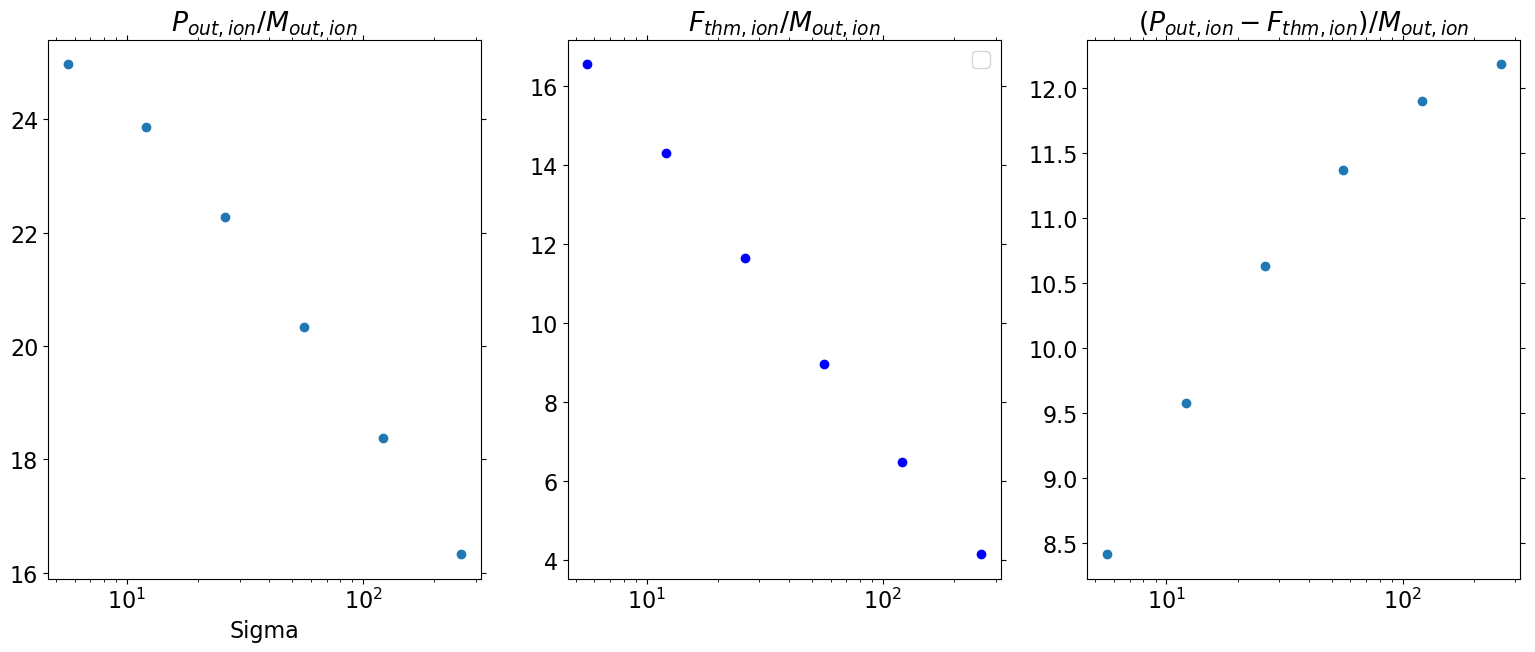

In [59]:
fig,axes=plt.subplots(1,3,figsize=(19,7))
axes[0].semilogx(D5['Sig']*s.u.mass,np.array(Pout_arr)/np.array(Mout_arr),'o')
axes[1].semilogx(D5['Sig']*s.u.mass,np.array(P_arr)/np.array(Mout_arr),'bo')
#axes[1].semilogx(D5['Sig']*s.u.mass,np.array(P_arr)/np.array(Pscale_arr),'ro',label='$F_{thm}/P_{scale}$')
#axes[1].semilogx(D5['Sig']*s.u.mass,np.array(P_arr)/np.array(Mev_arr),'go',label='$F_{thm}/M_{ev}c_i$')
axes[2].semilogx(D5['Sig']*s.u.mass,(np.array(Pout_arr)-np.array(P_arr))/np.array(Mout_arr),'o')
axes[0].set_xlabel('Sigma')
axes[0].set_title('$P_{out,ion}/M_{out,ion}$')
axes[1].set_title('$F_{thm,ion}/M_{out,ion}$')
axes[2].set_title('$(P_{out,ion}-F_{thm,ion})/M_{out,ion}$')
axes[1].legend()

### trace the cause of systematic differnce of outflow rate.
### the result we get from the simulation data is that ejection velocity ion gas decreases as density increases, which is defferent with Kim 2018.
### I distinguished ejected radial momentum into pressure term and other, then divide them by outflow mass.
### non-pressure momentum enjection per outflow mass increases as density increases. Maybe, initial velocity can be one cause of this phenomenon.
### Meanwhile, momentum enjection by pressure force per outflow mass increases as density decreases, and this term exceed the gap of non-pressure term.
### As you said, the inconsistency between our result and Kim 2018 may be casued by the radiation force. Both our result and Kim 2018 say that the cloud destruction by photoevaporation becomes ineffective at highly dense clouds. 
### And considering large fraction of radiation energy absorbed by dust at dense clouds, the absence of radiation force can cause this inconsistency.

In [61]:
def M_scale(models,mode=None):
    Ti4=0.8
    x_arr,val_arr,scale_arr=np.array([]),np.array([]),np.array([])
    if mode == 'plot':
        fig,axes=plt.subplots(1,2,figsize=(15,7))
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(s.basedir)

## proper combination of Qi and nH0 for scaling.
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49/n2
        x[~(x>0)]=0

## ion mass and its scaling relation
        M_scale=4.64*1e2*x*Ti4**0.82
        if mode == 'plot':
            axes[0].loglog(Qi49*n2**(-1),hd['M_sphere'],label=title_(str(model),['Q','n','M']))
            axes[1].semilogx(Qi49*n2**(-1),hd['M_sphere']/M_scale)
## average method - time averaged mass ion
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        #t_dest=s.par['time']['tlim']
        t_start=s.par['problem']['t0_src']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        ti=hd['time'][ind]
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        #w=dMevs[ind]*dt
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum((hd['M_sphere'])[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(M_scale[ind]*w)/(np.sum(w))])
    #figure setting
    if mode == 'plot':
        x=np.logspace(-1,2,100)
        M_scale=4.64*1e2*x*Ti4**0.82
        axes[0].loglog(x,M_scale,ls='--',lw=6,alpha=0.5)
        axes[0].loglog(x_arr,val_arr,'k*')
        axes[1].semilogx(x_arr,val_arr/scale_arr,'k*')
        axes[0].set_xlabel('$Q_{i,eff}n_{rms,ion}^{-1}$')
        axes[0].set_ylabel('${M}_{ion}$')    
        axes[0].set_xlim(1e-1,1e+4)
        axes[0].set_ylim(1e+2,1e+6)
        axes[1].set_ylabel('$F_M$')
    return x_arr,val_arr,scale_arr

In [66]:
x_arr,val_arr,scale_arr=M_scale(M5)
x_arr2,val_arr2,scale_arr2=M_scale(M6)

### As we discussed at meeting, time - averaged ion mass can't give some effective result.

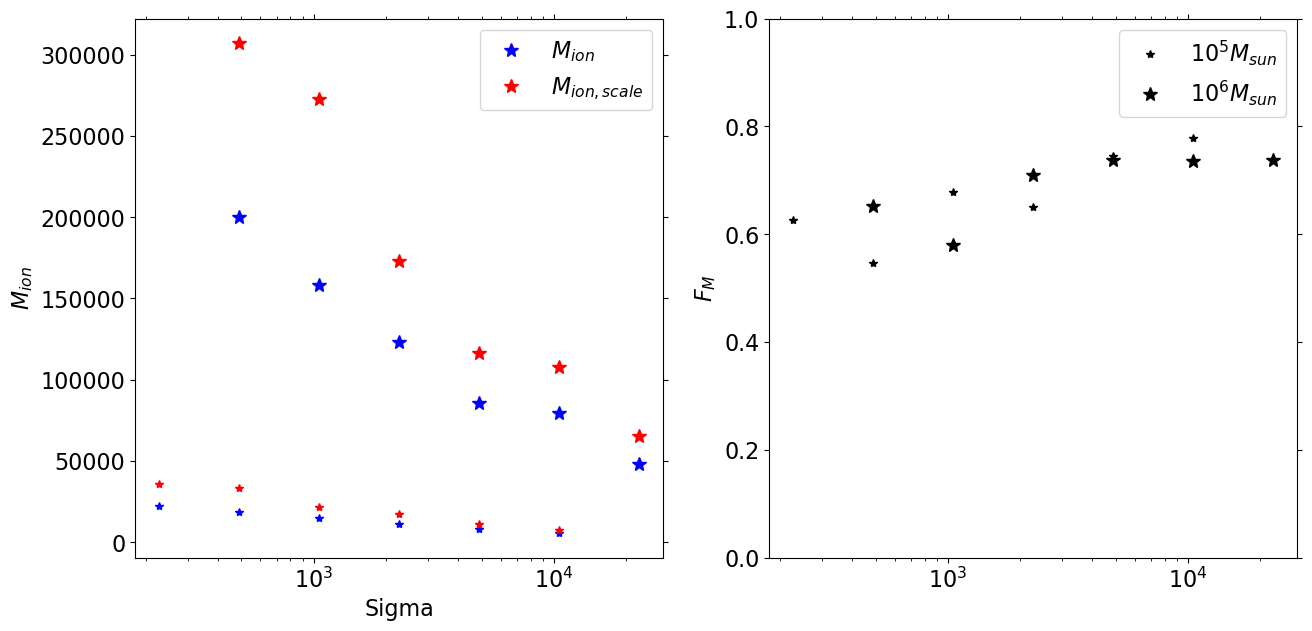

In [65]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$M_{ion}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$M_{ion,scale}$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$M_{ion}$')
axes[1].set_ylabel('$F_{M}$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

In [15]:
def q_scale(models,mode=None):
    Ti4=0.8
    x_arr,val_arr,scale_arr=np.array([]),np.array([]),np.array([])
    if mode == 'plot':
        fig,axes=plt.subplots(2,2,figsize=(15,14))
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(s.basedir)
        ti=np.array(h['time'])
        ts=hd['time']
        
## proper combination of Qi and n for scaling relation. 
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(1/3)*n2**(1/3)
        x[~(x>0)]=0

## shielding factor and its scaling relation.
        dMevs,Mevs = t_sample(ts,ti,np.array(h['dot_mass_ion_sphere']),arg='derivative')
        #dMevs = hd['M_out_ion']
        dNion=(dMevs/s.u.s/s.u.muH*s.u.cm**3)
        q_sh = Qi49*1e+49/dNion
        q_scale=74.6*x*Ti4**(-1.04)
        if mode == 'plot':
            axes[0][0].loglog(x,q_sh)
            axes[0][1].semilogy(ts/t_ff_(str(model)),Qi49**(1/3)*n2**(1/3))
            axes[1][0].semilogy(ts/t_ff_(str(model)),Qi49*1e+49)
            axes[1][1].semilogy(ts/t_ff_(str(model)),dNion)

## average method - evaporated mass - weighted average.
        #t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
        t_start=s.par['problem']['t0_src']
        t_dest=s.par['time']['tlim']
        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)

## exclude the snapshot at t~t0_src because of its extremely high value.
        for i in range(len(ind)):
            if ind[i] == True:
                ind[i]=False
                break
        ti=hd['time'][ind]
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        #dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        w=dMevs[ind]*dt
        #w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum(q_sh[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(q_scale[ind]*w)/(np.sum(w))])
## figure setting
    if mode == 'plot':
        x=np.logspace(-3,3,200)
        q_scale=74.6*x*Ti4**(-1.04)
        axes[0][0].loglog(x,q_scale,'--')
        axes[0][0].loglog(x_arr,val_arr,'k*')
        axes[0][0].set_xlabel('$Q_{i,eff}^{1/3}n_{rms}^{1/3}$')
        axes[0][1].set_ylabel('$Q_{i,eff}^{1/3}n_{rms}^{1/3}$')
        axes[0][0].set_ylabel('$q_{shield}$')
        axes[0][0].set_xlim(1e-3,1e+2)
        axes[0][0].set_ylim(1,1e+6)
        axes[0][1].set_xlabel('$t/t_{ff}$')
        axes[1][0].set_ylabel('$Q_{i,eff}$')
        axes[1][1].set_ylabel('$\dot{N}_{ion}$')
    return x_arr,val_arr,scale_arr

<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3181243/2214968034.py:66: SyntaxWarning: invalid escape sequence '\d'
  axes[1][1].set_ylabel('$\dot{N}_{ion}$')


In [60]:
x_arr,val_arr,scale_arr=q_scale(M5)

In [61]:
x_arr2,val_arr2,scale_arr2=q_scale(M6)

### scaling relation of shielding factor, excluding the extremely high value at t~t0_src.
### As density increases, F value decreases, but converges to a specific value at high density clouds. Can we understacnd this tendency?
### For example, because weights = $\dot{M}_{evap}$
### -> $F_{q,avg}={<q_{sh}>_{\dot{M}_{evap}}\over <q_{scale}>_{\dot{M}_{evap}}}={\int Q_{i,eff} dt/\int \dot{M}_{evap} dt \over <Q_{i,eff}/\dot{M}_{out,scale}>_{\dot{M}_{evap}}} ={\int Q_{i,eff} dt\over \int Q_{i,eff}{\dot{M}_{evap} \over \dot{M}_{out,scale}}dt} = <{\dot{M}_{evap} \over \dot{M}_{out,scale}}>_{Q_{i,eff}}^{-1}=<F_{\dot{M}_{evap}}>_{Q_{i,eff}}^{-1}$
### (the average version of Equation 34 in HII-WIND, and the result of $<F_{\dot{M}_{evap}}>_{Q_{i,eff}}^{-1}$ is also plotted at the below. the result is the same. Of course, it must equals.)
### if we can agree the above result about averaged $F_{\dot{M}}$, the converging tendency of $F_{q,avg}$ can be understood from HII-WIND paper. However, we know that there is time delay between $\dot{M}_{out}$ and $\dot{M}_{evap}$, and it can influence on this interpretation.

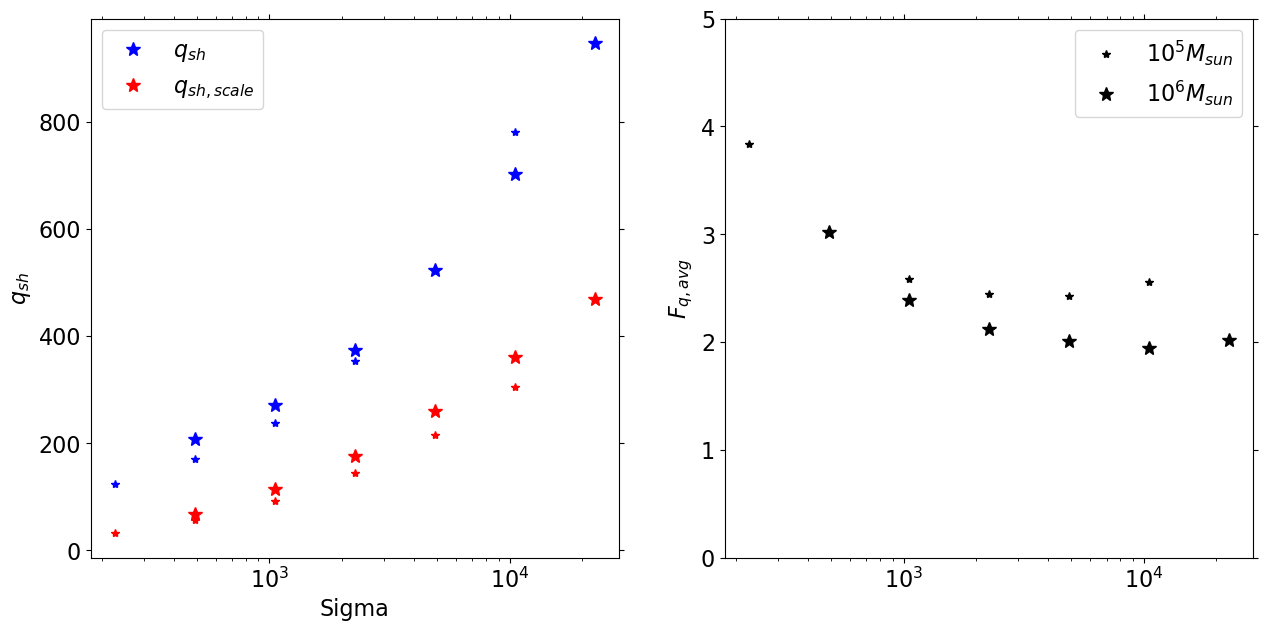

In [62]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$q_{sh}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$q_{sh,scale}$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$q_{sh}$')
axes[1].set_ylabel('$F_{q,avg}$')
axes[0].legend()
axes[1].set_ylim(0,5)

axes[1].legend()

In [51]:
def F_M_dot_avg(models,mode=None):
    x_arr,val_arr=np.array([]),np.array([])  
    for model in models:

        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(str(model))    


        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(2/3)/n2**(1/3)
        x[~(x>0)]=0

        M_out_scale=4.99*1000*x*0.8**1.04


## average method - simple time-average(weights = dt)
## select time interval for integration.
## t_dest=t_{ion,5%}, t_start=t0_src
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        t_start=s.par['problem']['t0_src']
        #t_dest=s.par['time']['tlim']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]

        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        for i in range(len(ind)):
            if ind[i] == True:
                ind[i]=False
                break
        ti=hd['time']
        dt=(ti[ind])[1:]-(ti[ind])[:-1]
        dt=np.hstack([dt,dt[-1]])
        dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        w=dt*Qi49[ind]
        F=((dMevs*s.u.mass/s.u.time).value)/M_out_scale
        val_arr=np.hstack([val_arr,np.sum(F[ind]*w)/(np.sum(w))])

    return x_arr,val_arr

In [52]:
x_w_arr,val_w_arr=F_M_dot_avg(M5)
x_w_arr2,val_w_arr2=F_M_dot_avg(M6)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3181243/2351550681.py:4: SyntaxWarning: invalid escape sequence '\d'
  axes.set_ylabel('$<F_{\dot{M}}>^{-1}_{Q_{i,eff}}$')


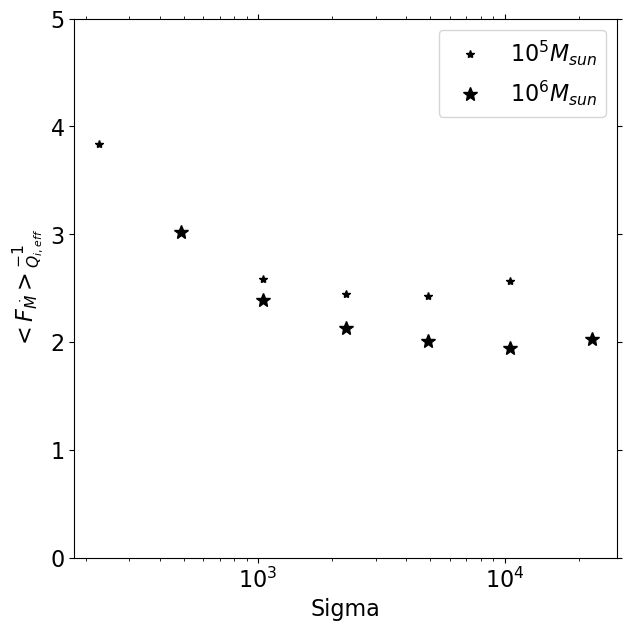

In [58]:
fig,axes=plt.subplots(1,1,figsize=(7,7))
axes.semilogx(D5['Sig'],1/val_w_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes.semilogx(D6['Sig'],1/val_w_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes.set_ylabel('$<F_{\dot{M}}>^{-1}_{Q_{i,eff}}$')
axes.set_ylim(0,5)
axes.set_xlabel('Sigma')
axes.legend()

### t_ej vs t_evap

In [25]:
def timescale(model):
## model data load
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    hd=load_hd(str(model))

## limit time interval for integration   
    M0=h['mass'][0]
    ti=np.array(h['time'])
    t_dest=np.array(h['time'][h['mass_neu']/h['mass'][0]>=0.05])[-1]
    t_start=s.par['problem']['t0_src']
    #t_dest=s.par['time']['tlim']
    #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
    ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
    ts=hd['time']
    dt=ts[1:]-ts[:-1]
    dt=np.hstack([dt,dt[-1]])
    dMevs,Mevs = t_sample(hd['time'],ti,np.array(h['dot_mass_ion_sphere']),arg='derivative')
    Mneu = t_sample(hd['time'],ti,np.array(h['mass_neu']))
    w=dt
    #w=dt*dMevs
## average mass evaporation rate : time-averaged value
    M_ev_avg=np.sum(dMevs[ind]*w[ind])/np.sum(w[ind])
    #M_ev_avg=np.sum(dMevs*dMevs*dt)/np.sum(dMevs*dt)

## characteristic evaporation time sacle
    t_ev_=Mevs[-1]/M_ev_avg

## characteristic ejection time sacle : how can one extract ejection velocity of neutral gas ejection not effected by photoionization feedback?
## in this, I just selected time interval t=0 ~ t=t0_src -> extract ejection velocity only by initial turbulence, expected to proportionate to t_ff
    ti=np.array(h['time'])
    pn_out=np.array(h['dot_pr_out_neu'])
    mn_out=np.array(h['dot_mass_out_neu'])
    pn_out,Pn_out=t_sample(ts,ti,pn_out,'derivative')
    mn_out,Mn_out=t_sample(ts,ti,mn_out,'derivative')
    
    vout=pn_out/mn_out
    vout_=Pn_out[ts<=s.par['problem']['t0_src']][-1]/Mn_out[ts<=s.par['problem']['t0_src']][-1]
    #vout_=s.par['problem']['v3d']
    #r_cl=s.par['problem']['r0']*s.par['problem']['revap_over_r0']
    r_cl = s.par['mesh']['x1max']
    return ts[ind],Mneu[ind]/dMevs[ind],r_cl/vout[ind],r_cl/vout_,t_ev_,t_ff_(str(model))

In [20]:
t_ev_arr,t_ej_arr,t_ff_arr=np.array([]),np.array([]),np.array([])
#color=['r','g','b','c','m','y']
#fig,axes=plt.subplots(1,2,figsize=(15,7))
for n, model in enumerate(M5[:]):
    ts,t_ev,t_ej,t_ej_avg,t_ev_avg,t_ff=timescale(model)
    #axes[0].semilogy(ts/ts[-1],t_ev,color[n]+'-')
    #axes[0].semilogy(ts/ts[-1],t_ej,color[n]+'--')
    t_ev_arr=np.hstack([t_ev_arr,t_ev_avg])
    t_ej_arr=np.hstack([t_ej_arr,t_ej_avg])
    t_ff_arr=np.hstack([t_ff_arr,t_ff])

#line1,=axes[0].plot([],[],'k-',label='$t_{evap}$')
#line2,=axes[0].plot([],[],'k--',label='$t_{ej}$')
#leg=axes[0].legend(handles=[line1,line2],loc='center left')
#axes[0].add_artist(leg)

In [21]:
t_ev_arr2,t_ej_arr2,t_ff_arr2=np.array([]),np.array([]),np.array([])
#color=['r','g','b','c','m','y']
#fig,axes=plt.subplots(1,2,figsize=(15,7))
for n, model in enumerate(M6[:]):
    ts,t_ev,t_ej,t_ej_avg,t_ev_avg,t_ff=timescale(model)
    #axes[0].semilogy(ts/ts[-1],t_ev,color[n]+'-')
    #axes[0].semilogy(ts/ts[-1],t_ej,color[n]+'--')
    t_ev_arr2=np.hstack([t_ev_arr2,t_ev_avg])
    t_ej_arr2=np.hstack([t_ej_arr2,t_ej_avg])
    t_ff_arr2=np.hstack([t_ff_arr2,t_ff])
#line1,=axes[0].plot([],[],'k-',label='$t_{evap}$')
#line2,=axes[0].plot([],[],'k--',label='$t_{ej}$')
#leg=axes[0].legend(handles=[line1,line2],loc='center left')
#axes[0].add_artist(leg)

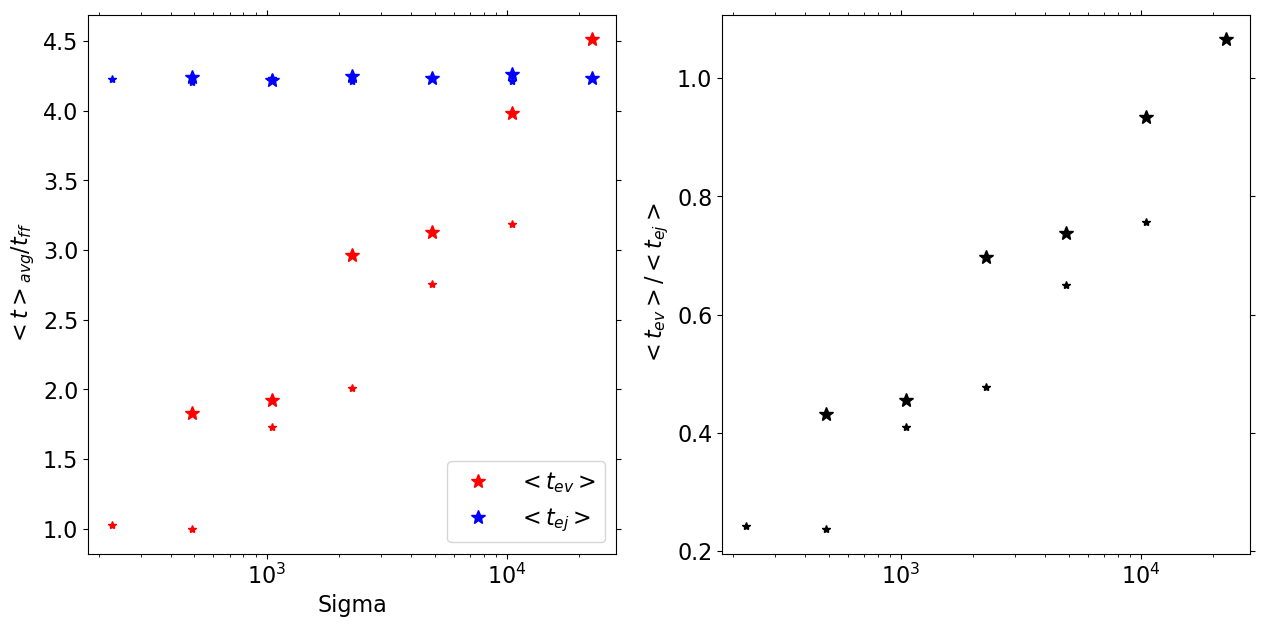

In [24]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],t_ev_arr/t_ff_arr,'r*',ms=6)
axes[0].semilogx(D5['Sig'],t_ej_arr/t_ff_arr,'b*',ms=6)
axes[1].semilogx(D5['Sig'],t_ev_arr/t_ej_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],t_ev_arr2/t_ff_arr2,'r*',ms=10,label='$<t_{ev}>$')
axes[0].semilogx(D6['Sig'],t_ej_arr2/t_ff_arr2,'b*',ms=10,label='$<t_{ej}>$')
axes[1].semilogx(D6['Sig'],t_ev_arr2/t_ej_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$<t>_{avg}/t_{ff}$')
axes[1].set_ylabel('$<t_{ev}>/<t_{ej}>$')
axes[0].legend()

### - high density cloud : large t_ev, small t_ej
### - low density cloud : small t_ev, large t_ej
### one can expect some simple scaling relation based on the assumption almost evaporated mass escape from the domain. 
### -> at least, we can know $<\dot{M}_{ev}>_{time} = <\dot{M}_{out,ion}>_{time}$
### $t_{ej} \sim r_{cl}/v_{ej} \sim (M_0/n_{rms})^{1/3}/v_{ej}, t_{ev} \sim M_{evap}/<\dot{M}_{ev}> \sim M_{0} Q_{i,eff}^{-2/3} n_{rms}^{1/3}$
### $ t_{ev}/t_{ej} \sim M_0^{2/3} v_{ej} Q_{i,eff}^{-2/3} n_{rms}^{2/3}$
### if $v_{ej}=\sigma_{3d} \sim M_0^{1/2}r_{cl}^{-1/2} -> t_{ev}/t_{ej} \sim M_0Q_{i,eff}^{-2/3}n_{rms}^{5/6}$
### *Of course, there are some deviation parameter, such as $f_{eff}, n_{rms}/n_{H^0}, \epsilon_{evap}=M_{evap}/M_0, ...$

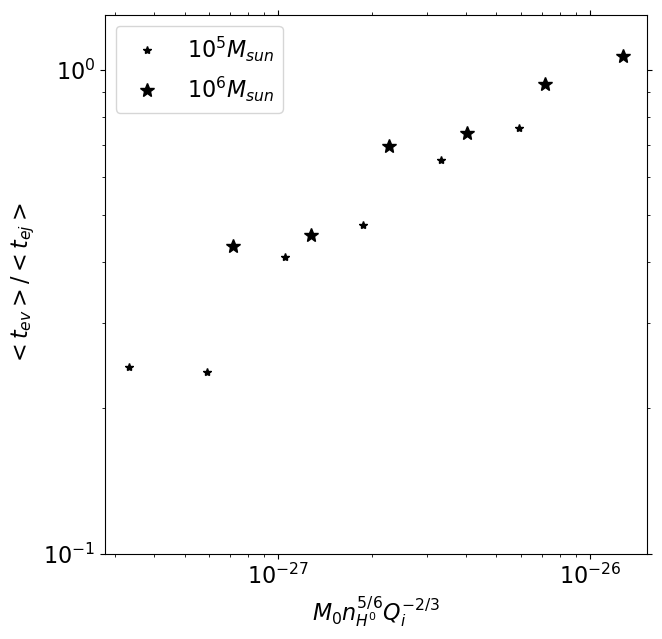

In [34]:
fig,axes=plt.subplots(1,1,figsize=(7,7))

x5=D5['M']*D5['nH0']**(5/6)*D5['Qi']**(-2/3)
axes.loglog(x5,t_ev_arr/t_ej_arr,'k*',ms=6,label='$10^5M_{sun}$')

x6=D6['M']*D6['nH0']**(5/6)*D6['Qi']**(-2/3)
axes.loglog(x6,t_ev_arr2/t_ej_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes.set_xlabel('$M_0n_{H^0}^{5/6}Q_{i}^{-2/3}$')
axes.set_ylabel('$<t_{ev}>/<t_{ej}>$')
axes.set_ylim(1e-1,1.3)
axes.legend()